# Image Classification using AWS SageMaker

 In this project, you will be using AWS Sagemaker to finetune a pretrained model that can perform image classification. You will have to use Sagemaker profiling, debugger, hyperparameter tuning and other good ML engineering practices to finish this project. The choice of dataset is up to you. For instance, you can use the dog breed classication(opens in a new tab) dataset to classify between different breeds of dogs in images.

## Instructions

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.

**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug seaborn -q

In [2]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
from sagemaker import get_execution_role
import boto3

import glob, os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

Now, let's extract data from s3 and count number of image.

In [3]:
# Command to download and unzip data
# !wget --no-check-certificat https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
# !unzip -q dogImages.zip 

In [5]:
# Get current working directory
current_dir = os.getcwd()

# Define a search pattern to find all JPG files within four subdirectories
search_pattern = os.path.join(current_dir, "*/" * 3, "*.jpg")

# Find all JPG files matching the pattern
file_pth_lst = glob.glob(search_pattern)

# Filter files based on presence of "train", "valid", or "test" in the path
train_pth_lst = [pth for pth in file_pth_lst if "train" in pth]
valid_pth_lst = [pth for pth in file_pth_lst if "valid" in pth]
test_pth_lst = [pth for pth in file_pth_lst if "test" in pth]

In [6]:
print(f"""
    number of image in train:{len(train_pth_lst)} \n
    number of image in valid:{len(valid_pth_lst)} \n
    number of image in test:{len(test_pth_lst)}""")


    number of image in train:6680 

    number of image in valid:835 

    number of image in test:836


### Extracting label and class from data path
This structure makes it easy to identify which class each image belongs to within the dataset.

* example1: /dogImages/dataset type/label.class/class_number.jpg 
* exapmple2: /dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg

### Explanation of each part

* /dogImages/: The top-level directory name. (root directory).
* dataset type: Indicates the type of dataset. (e.g., train, valid, test).
* label.class: Represents the label and class of the image. label means the label name, and class means the class name. 
* class_number.jpg: The class number and the file name of the image. class_number is a unique number for the image within that class (e.g., 1.jpg, 2.jpg).


In [7]:
def get_pth2metadata(pth_list):
    df =pd.DataFrame([pth.split('/')[-2].split('.') for pth in pth_list])
    df.columns = ['label','class']
    df['label'] = df['label'].astype(int)
    
    df['filenames'] = [pth.split('/')[-1] for pth in pth_list]
    
    agg_df = pd.DataFrame(df['class'].value_counts()).reset_index()
    agg_df = agg_df.sort_values(by='class')
    return df, agg_df

train_df, train_agg_df = get_pth2metadata(train_pth_lst)
valid_df, valid_agg_df = get_pth2metadata(valid_pth_lst)
test_df, test_agg_df = get_pth2metadata(test_pth_lst)

In [8]:
len(train_df['class'].unique())

133

The dataset contains images from 133 dog breeds divided into training, testing and validation datasets.

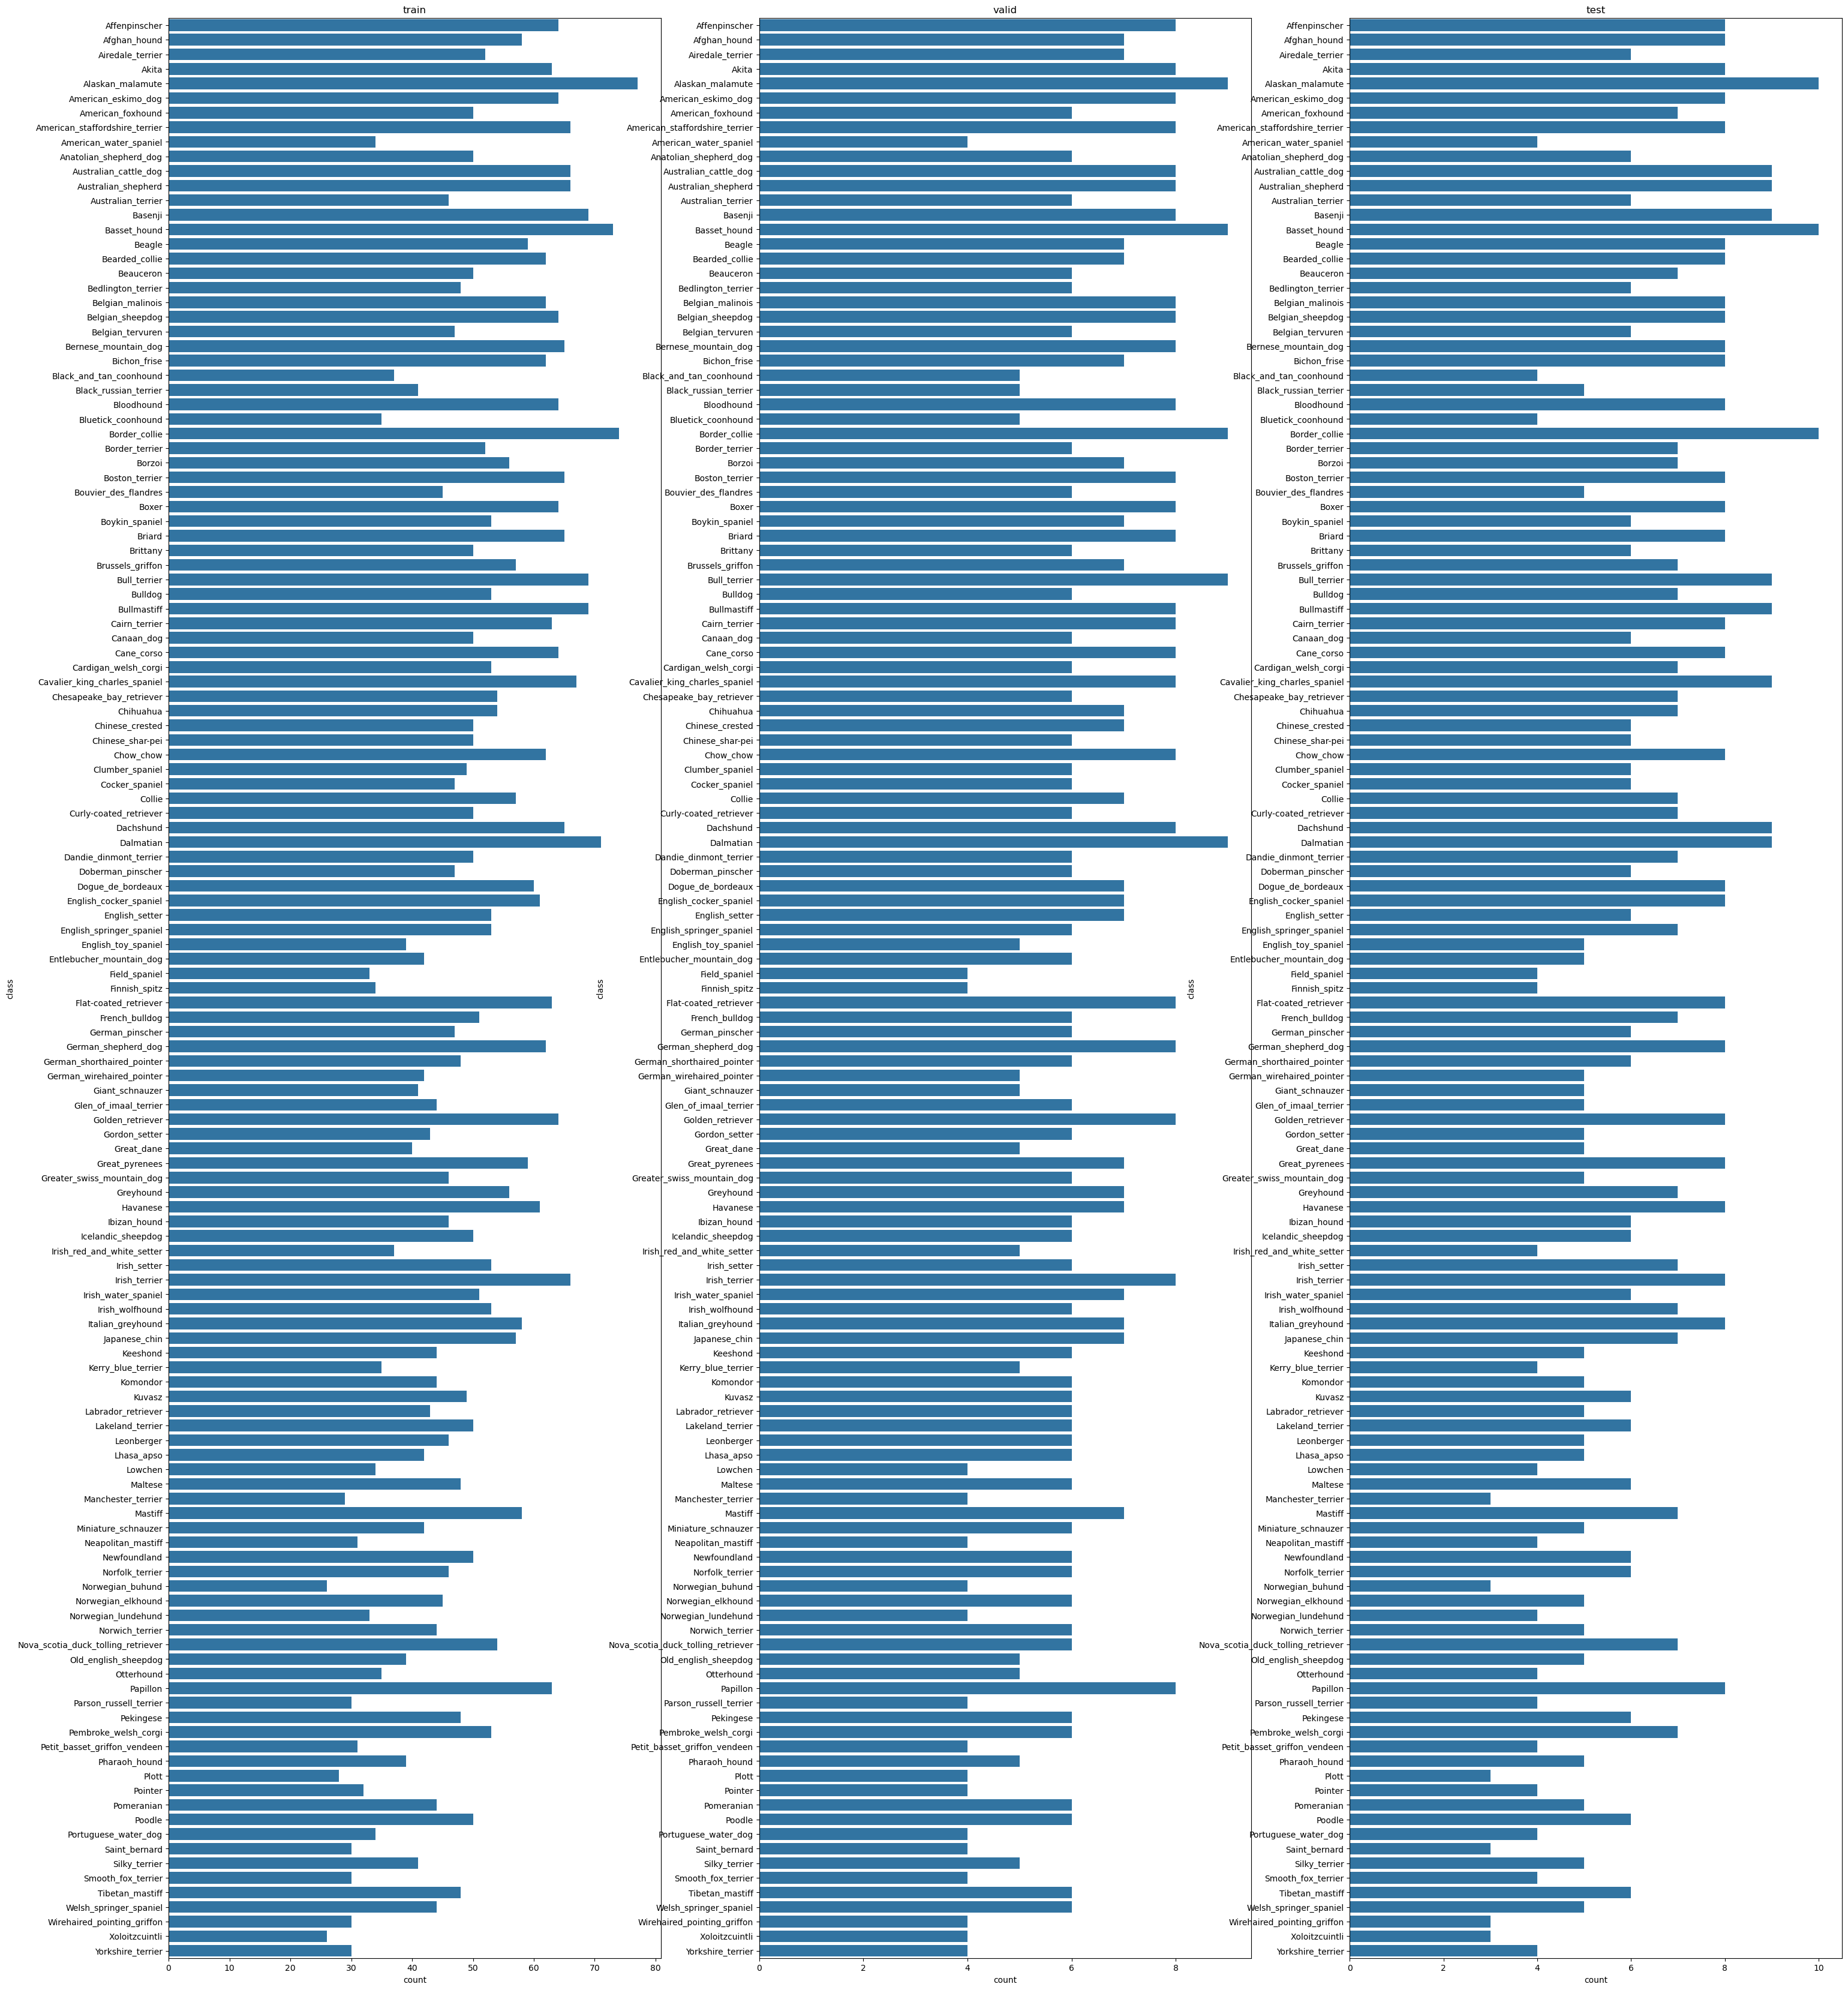

In [9]:
plt.figure(figsize=[36, 42])
plt.subplot(1,3,1)
sns.barplot(data=train_agg_df, x='count', y='class');
plt.title('train');

plt.subplot(1,3,2)
sns.barplot(data=valid_agg_df, x='count', y='class');
plt.title('valid');

plt.subplot(1,3,3)
sns.barplot(data=test_agg_df, x='count', y='class');
plt.title('test');

The train data and the valid/test data show a similar trend in the number of data per label, although the number of images differs.

### Load data to S3

In [10]:
sagemaker_session = sagemaker.Session(default_bucket="sagemaker-studio-146700155215-5c7uj0emdok")

bucket = sagemaker_session.default_bucket()
print("Default Bucket: {}".format(bucket))

region = sagemaker_session.boto_region_name
print("AWS Region: {}".format(region))

role = get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-studio-146700155215-5c7uj0emdok
AWS Region: us-west-2
RoleArn: arn:aws:iam::146700155215:role/service-role/AmazonSageMaker-ExecutionRole-20240708T070637


#### Load Image Data

In [11]:
os.environ["DEFAULT_S3_BUCKET"] = bucket

!aws s3 sync ./dogImages/train s3://${DEFAULT_S3_BUCKET}/nd009t-c2/train/ --quiet
!aws s3 sync ./dogImages/valid s3://${DEFAULT_S3_BUCKET}/nd009t-c2/valid/ --quiet
!aws s3 sync ./dogImages/test s3://${DEFAULT_S3_BUCKET}/nd009t-c2/test/ --quiet

In [12]:
s3 = boto3.resource('s3')
bucket_boto3 = s3.Bucket(bucket)
object_key = [obj.key for obj in bucket_boto3.objects.all()]

print('Check number of image in s3 and unzipped image files in train/valid/test folder')
print(f'train image:{len([key for key in object_key if "train" in key])==len(train_pth_lst)}')
print(f'valid image:{len([key for key in object_key if "valid" in key])==len(valid_pth_lst)}')
print(f'test image:{len([key for key in object_key if "test" in key])==len(test_pth_lst)}')

Check number of image in s3 and unzipped image files in train/valid/test folder
train image:True
valid image:True
test image:True


#### Load Label Data

In [18]:
def to_metadata_file(df, prefix):
    df = df.reset_index().drop(columns=['class'],axis=1)
    return df.to_csv(
        f"./metadata/{prefix}.lst", sep="\t", index=False, header=False
    )

to_metadata_file(train_df, 'train')
to_metadata_file(valid_df, 'valid')
to_metadata_file(test_df, 'test')

In [26]:
s3 = boto3.Session().resource('s3')

s3.Bucket(bucket).Object('nd009t-c2/metadata/train.lst').upload_file('./metadata/train.lst')
s3.Bucket(bucket).Object('nd009t-c2/metadata/valid.lst').upload_file('./metadata/valid.lst')
s3.Bucket(bucket).Object('nd009t-c2/metadata/test.lst').upload_file('./metadata/test.lst')

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [ ]:
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

In [ ]:
#TODO: Declare your HP ranges, metrics etc.

In [ ]:
#TODO: Create estimators for your HPs

estimator = # TODO: Your estimator here

tuner = # TODO: Your HP tuner here

In [ ]:
# TODO: Fit your HP Tuner
tuner.fit() # TODO: Remember to include your data channels

In [ ]:
# TODO: Get the best estimators and the best HPs

best_estimator = #TODO

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [ ]:
# TODO: Set up debugging and profiling rules and hooks

In [ ]:
# TODO: Create and fit an estimator

estimator = # TODO: Your estimator here

In [ ]:
# TODO: Plot a debugging output.

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [ ]:
# TODO: Display the profiler output

## Model Deploying

In [ ]:
# TODO: Deploy your model to an endpoint

predictor=estimator.deploy() # TODO: Add your deployment configuration like instance type and number of instances

In [ ]:
# TODO: Run an prediction on the endpoint

image = # TODO: Your code to load and preprocess image to send to endpoint for prediction
response = predictor.predict(image)

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()